# Problem Statement

Create a model that outputs expected rate levels or movements based on sentiment measurements from Fed statements, Fed press briefings, and other events with Fed speakers. Explore impacts on nominal yields, real yields, and yield curve spreads. If data is available, also explore the impacts on STIR markets (Eurodollar and Fed Funds futures).

Measure the time delay between news story/Fed press release and market reaction. This will require the use of the previous two models to output an expected reaction so that we can measure how long the market reaches that expected reaction. Again, measure impact specifically on nominal yields, real yields, and yield curve spreads. Develop a model that outputs the expected time between a news story release and the expected reaction being priced into markets.

#### Steps 3
- Use a variety of time frames to measure movement

# Data Collection and Cleaning

#### Import Statements

In [59]:
import nltk
import quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import requests as req
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression


nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
sia = SentimentIntensityAnalyzer()

#### Compiling Links to HTML files of all statements dating back to 2016

In [3]:

  
# Requesting for the website
Web = req.get('https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm')
  
# Creating a BeautifulSoup object and specifying the parser
s = BeautifulSoup(Web.text, 'lxml')

# Links to html files of all statements
links = ['https://www.federalreserve.gov' + tag['href'] for tag in s.find_all('a') if tag.text == 'HTML' 
                                           and tag['href'][:34] == '/newsevents/pressreleases/monetary']


#### Using links to put statements into strings

In [108]:
statements = {}
i=0
for link in links:
    if i%5 == 0:
        print('Progress:', str(round(i/len(links)*100, 1)) + '%')
    i += 1
    date = link[-13:-5]
    Web = req.get(link)
    s = BeautifulSoup(Web.text, 'lxml')
    statements[date] = (' '.join([tag.text for tag in s.find('div', id='article').find_all('p', class_=None)][:-2]))
print('Number of Statements:', len(statements))

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
Number of Statements: 50


#### Measure Sentiment Score for given String

In [5]:
def sent_score(statement):
    """
    Returns the SentimentIntensityAnalyzer sentiment score for the string that is passed in.
    """
    scores = sia.polarity_scores(statement)
    return scores['compound']

#### Histogram and Table of all past scores

(array([ 2.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  5., 37.]),
 array([0.2023 , 0.28183, 0.36136, 0.44089, 0.52042, 0.59995, 0.67948,
        0.75901, 0.83854, 0.91807, 0.9976 ]),
 <BarContainer object of 10 artists>)

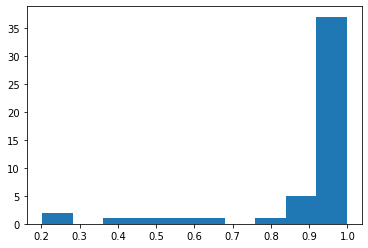

In [177]:
plt.hist(np.array([sent_score(statement) for statement in statements.values()]))

In [205]:
pd.DataFrame({'Date': [i[:4] + '-' + i[4:6] + '-' + i[6:] for i in statements.keys()],
            'Score': [sent_score(statement) for statement in statements.values()]})

,Date,Score
0,2021-01-27,0.9642
1,2021-03-17,0.9732
2,2021-04-28,0.9916
3,2021-06-16,0.9928
4,2021-07-28,0.9934
5,2021-09-22,0.9942
6,2021-11-03,0.9975
7,2020-01-29,0.2023
8,2020-03-03,0.5106
9,2020-03-15,0.9875


#### Dealing with outlier

In [192]:
print('Sentiment Score of outlier:', sent_score(list(statements.values())[24]))
print('Date of outlier:', list(statements.keys())[24])
try:
    statements.pop('20191030')
    print('Outlier from Oct 2019 removed')
except:
    print('Outlier from Oct 2019 already removed, disregard above info')

Sentiment Score of outlier: 0.6249
Date of outlier: 20191211
Outlier from Oct 2019 already removed, disregard above info


In [179]:
quandl.ApiConfig.api_key = '6YYqcHNouxRSb8q5_yLc'

<AxesSubplot:xlabel='Date'>

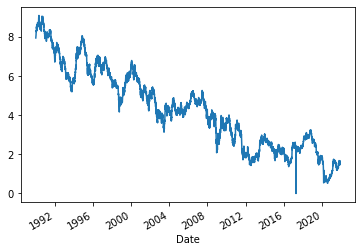

In [180]:
quandl.get("USTREASURY/YIELD", authtoken="6YYqcHNouxRSb8q5_yLc")['10 YR'].plot()

In [182]:
ten_year = quandl.get("USTREASURY/YIELD", authtoken="6YYqcHNouxRSb8q5_yLc")['10 YR']

def movement(date, prices=ten_year):
    dates = [price.strftime('%Y%m%d') for price in prices.index]
    if date in dates:
        index = dates.index(date)
        pre_date = dates[index-1]
        post_date = dates[index+1]
        return prices[post_date] - prices[pre_date]

In [206]:
def plot(trendline=True, prices=ten_year):
    final_df = pd.DataFrame({'Date': list(statements.keys()),
                  'Movement': [movement(day, prices=prices) for day in statements.keys()],
                  'Sentiment Score': [sent_score(statement) for statement in statements.values()]})
    final_df.dropna(axis=0, inplace=True)
    x_arr = np.array(final_df['Sentiment Score'])
    x = x_arr.reshape((-1, 1))
    y = np.array(final_df['Movement'])
    plt.scatter(x, y)
    plt.plot(x, [0 for i in range(len(x))])
    plt.title('Sentiment Score vs. Movement: ' + prices.name)
    plt.xlabel('Sentiment Score (-1 to 1)')
    plt.ylabel('Yield Movement (%)')
    if trendline:
        model = LinearRegression().fit(x, y)
        m = model.coef_
        b = model.intercept_
        plt.scatter(x, y)
        plt.plot(x, m*x + b)
        plt.title('Linear Regression: ' + prices.name)
        r_sq = model.score(x,y)
        print(prices.name + ':')
        print('r^2:', round(r_sq, 4))
        print(str(round(r_sq*100,1)) + 
              '% of the change in Movement is explained by the change in Sentiment Score')
    plt.show()

# Results and Analysis

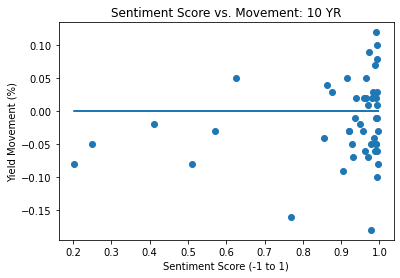

In [207]:
plot(trendline=False)

10 YR:
r^2: 0.0434
4.3% of the change in Movement is explained by the change in Sentiment Score


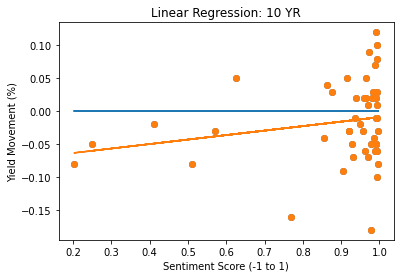

In [199]:
plot()

Text(0.5, 1.0, 'Residual Plot')

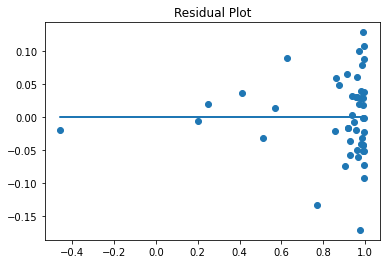

In [200]:
plt.scatter(x, y - (m*x_arr + b))
plt.plot(x, [0 for i in range(len(x))])
plt.title('Residual Plot')

Due to the heavy concentration of data points to the right of the graph, a linear regression could be problematic.

1 MO:
r^2: 0.024
2.4% of the change in Movement is explained by the change in Sentiment Score


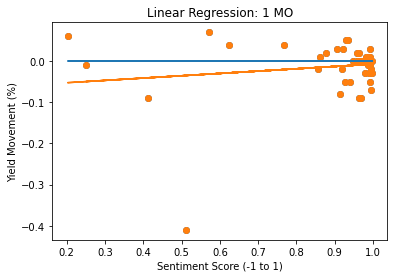

2 MO:
r^2: 0.105
10.5% of the change in Movement is explained by the change in Sentiment Score


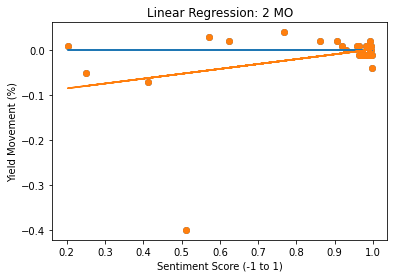

3 MO:
r^2: 0.1093
10.9% of the change in Movement is explained by the change in Sentiment Score


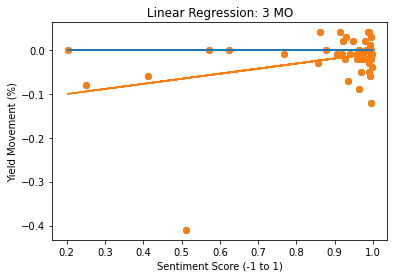

6 MO:
r^2: 0.1655
16.6% of the change in Movement is explained by the change in Sentiment Score


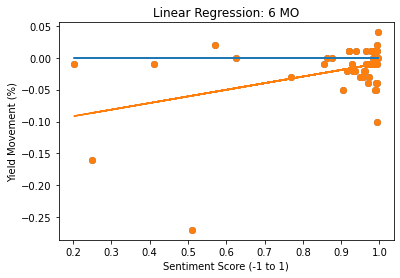

1 YR:
r^2: 0.2223
22.2% of the change in Movement is explained by the change in Sentiment Score


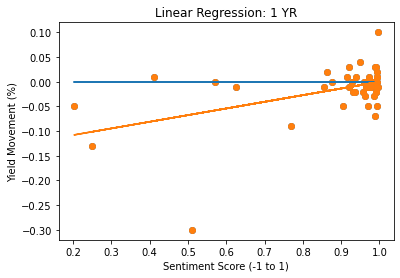

2 YR:
r^2: 0.1046
10.5% of the change in Movement is explained by the change in Sentiment Score


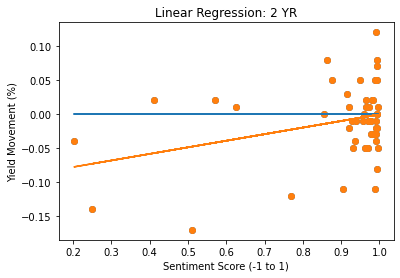

3 YR:
r^2: 0.1071
10.7% of the change in Movement is explained by the change in Sentiment Score


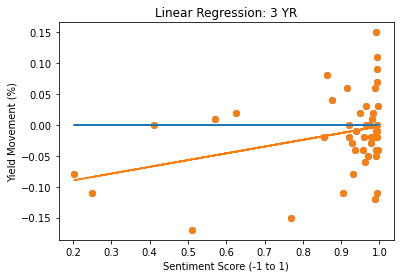

5 YR:
r^2: 0.0581
5.8% of the change in Movement is explained by the change in Sentiment Score


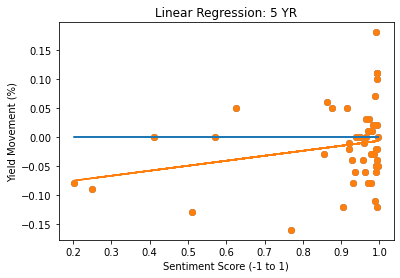

7 YR:
r^2: 0.0454
4.5% of the change in Movement is explained by the change in Sentiment Score


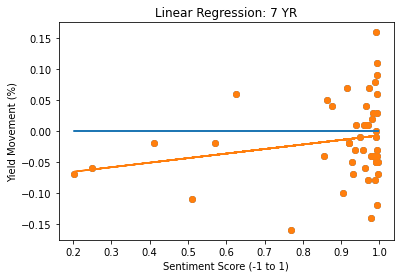

10 YR:
r^2: 0.0434
4.3% of the change in Movement is explained by the change in Sentiment Score


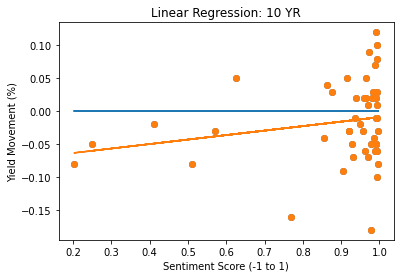

20 YR:
r^2: 0.0117
1.2% of the change in Movement is explained by the change in Sentiment Score


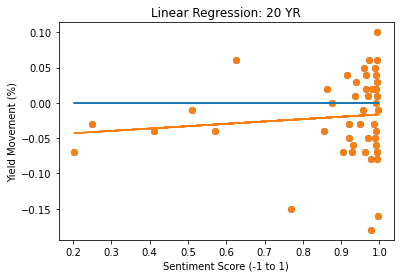

30 YR:
r^2: 0.0065
0.6% of the change in Movement is explained by the change in Sentiment Score


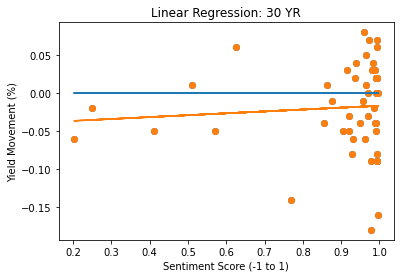

In [201]:
data = quandl.get("USTREASURY/YIELD", authtoken="6YYqcHNouxRSb8q5_yLc")
all_prices = [data[i] for i in data.columns]
for prices in all_prices:
    plot(prices=prices)

As we can see, all of the relationships shown in the graphs are positive, although their strengths vary. This makes sense becasue when the FED becomes more optimistic, we expect interest rates to rise (or at least not fall by as much).

It is interesting to not that even for high sentiment values, every model still predicted negative yield movement.